# **Prefix-tuning**

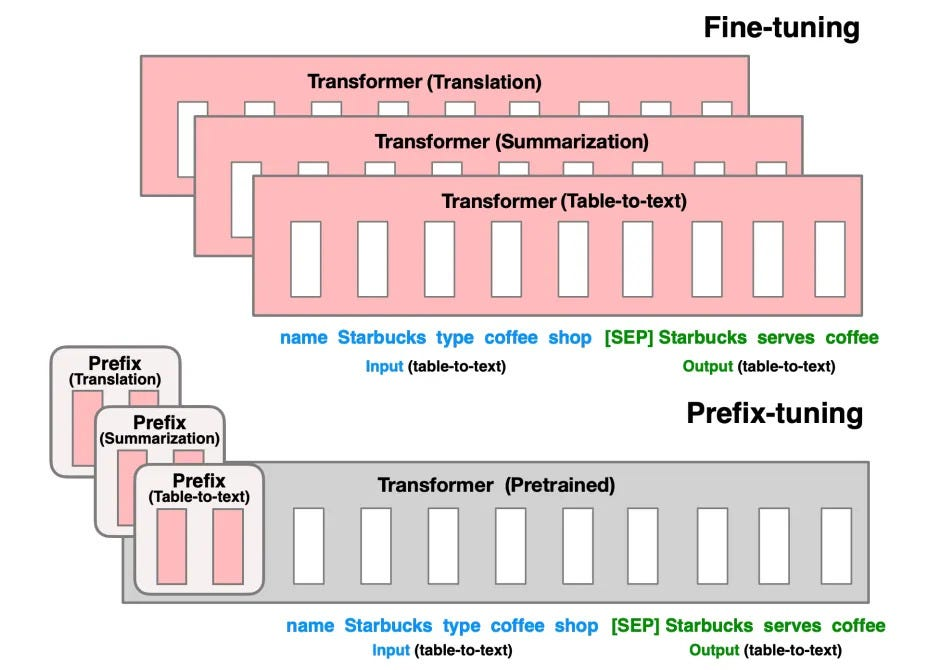

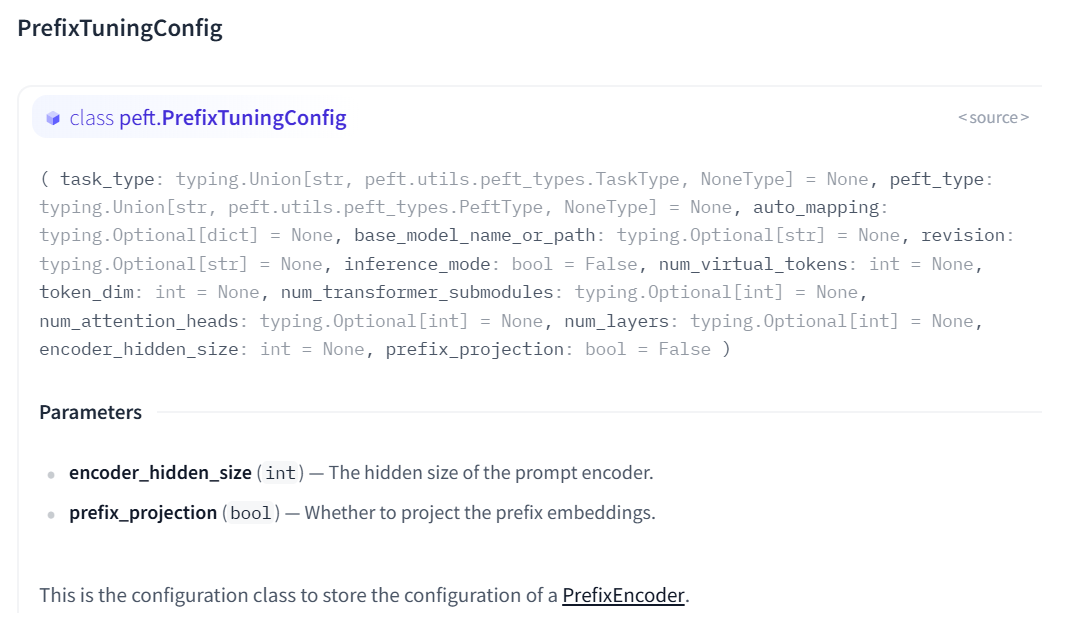

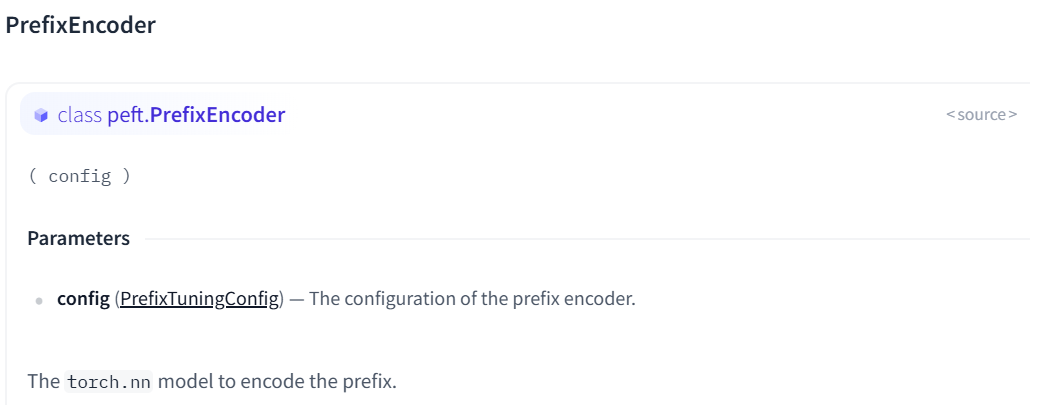

Example:

```
from peft import PrefixEncoder, PrefixTuningConfig

config = PrefixTuningConfig(
    peft_type="PREFIX_TUNING",
    task_type="SEQ_2_SEQ_LM",
    num_virtual_tokens=20,
    token_dim=768,
    num_transformer_submodules=1,
    num_attention_heads=12,
    num_layers=12,
    encoder_hidden_size=768,
)
prefix_encoder = PrefixEncoder(config)
```

**Attributes:**

* embedding `(torch.nn.Embedding)` — The embedding layer of the prefix encoder.
* transform `(torch.nn.Sequential)` — The two-layer MLP to transform the prefix embeddings if prefix_projection is True.
* prefix_projection `(bool)` — Whether to project the prefix embeddings.

* Input shape:` (batch_size, num_virtual_tokens)

* Output shape: (batch_size, num_virtual_tokens, 2*layers*hidden)

# **First Example:**

#### Apply prefix tuning to train a t5-large model on the sentences_allagree subset of the [financial_phrasebank](https://huggingface.co/datasets/takala/financial_phrasebank) dataset.

**Dataset Summary**

Polar sentiment dataset of sentences from financial news. The dataset consists of 4840 sentences from English language financial news categorised by sentiment. The dataset is divided by agreement rate of 5-8 annotators.


**Supported Tasks and Leaderboards**

Sentiment Classification



**Data Instances:**
```
{ "sentence": "Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .","label": "negative"
}
```

**Data Fields**

* sentence: a tokenized line from the dataset
* label: a label corresponding to the class as a string: **'positive'**, **'negative' **or **'neutral'**

**Data Splits**

There's no train/validation/test split.

However the dataset is available in four possible configurations depending on the percentage of agreement of annotators:

`sentences_50agree`; Number of instances with >=50% annotator agreement: 4846

`sentences_66agree`: Number of instances with >=66% annotator agreement: 4217

`sentences_75agree`: Number of instances with >=75% annotator agreement: 3453

 `sentences_allagree`: Number of instances with 100% annotator agreement: 2264

In [ ]:
!pip install -q peft transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.4 MB/s eta 0:00:00


Start by defining the model and tokenizer, text and label columns, and some hyperparameters so it’ll be easier to start training faster later. Set the environment variable `TOKENIZERS_PARALLELSIM` to `false` to disable the fast Rust-based tokenizer which processes data in parallel by default so you can use multiprocessing in Python.

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig, TaskType
import torch
from datasets import load_dataset
import os

## disable tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# only use GPU 3 if multiple GPUs are available
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

device = "cuda"
model_name_or_path = "t5-large"
tokenizer_name_or_path = "t5-large"

checkpoint_name = "financial_sentiment_analysis_prefix_tuning_v1.pt"

# dataset input and output column names
text_column = "sentence"
label_column = "text_label"

## max token length for tokenizer
max_length = 128
lr = 1e-2
num_epochs = 5
batch_size = 8

**Load dataset:**

For this guide, you’ll train on the sentences_allagree subset of the financial_phrasebank dataset. This dataset contains financial news categorized by sentiment.

Use 🤗 Datasets `train_test_split` function to create a training and validation split and convert the label value to the more readable text_label. All of the changes can be applied with the `map` function:

 ### [ `train_test_split`](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) function

Return a dictionary (datasets.DatasetDict) with two random train and test subsets (`train` and `test` Dataset splits).
Splits are created from the dataset according to `test_size`, `train_size` and `shuffle`.

This method is similar to scikit-learn `train_test_split`.

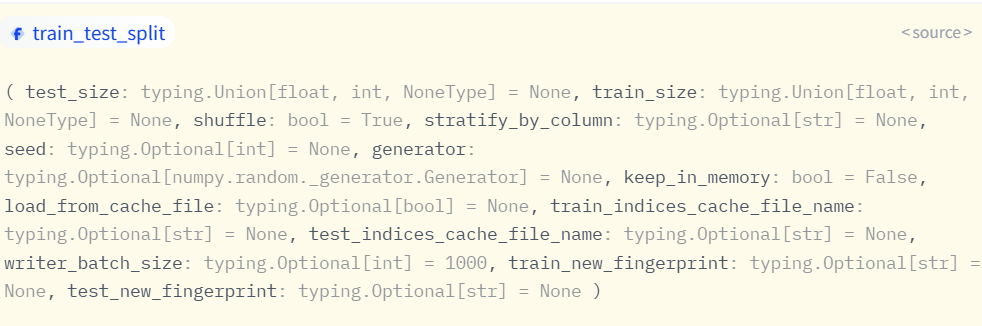

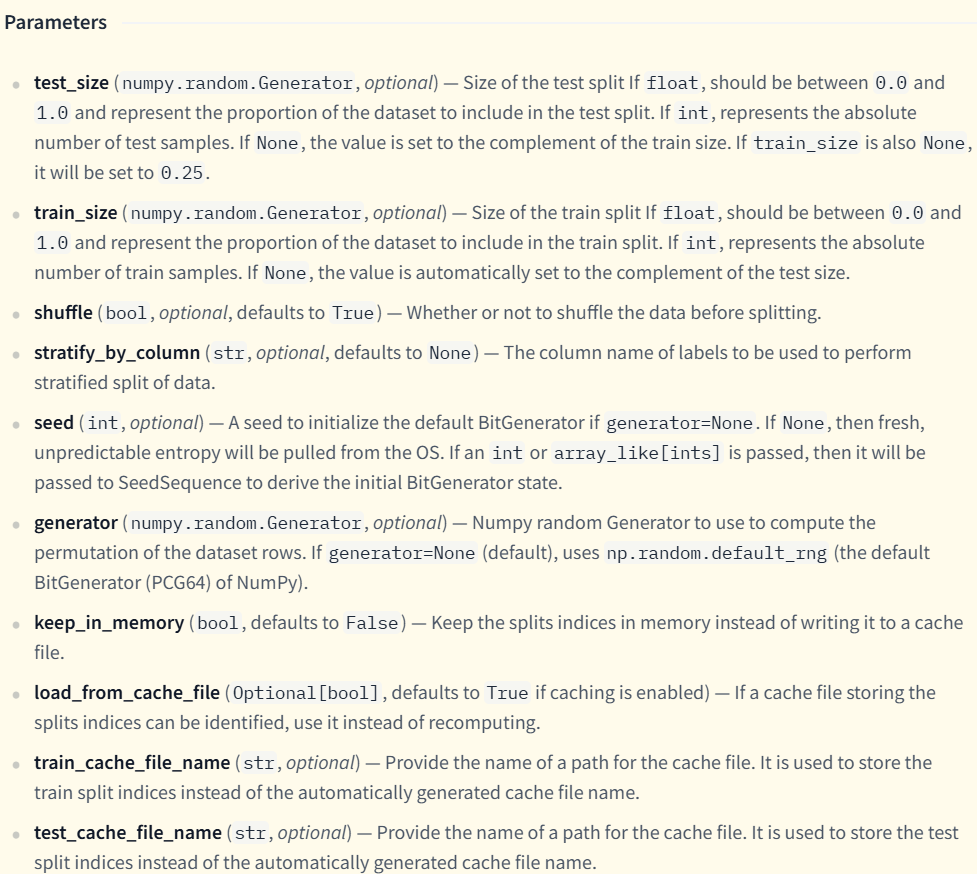

Example:

```
from datasets import load_dataset
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes", split="validation")
ds = ds.train_test_split(test_size=0.2, shuffle=True)
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 852
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 214
    })
})

# set a seed
ds = ds.train_test_split(test_size=0.2, seed=42)

# stratified split
ds = load_dataset("imdb",split="train")
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
ds = ds.train_test_split(test_size=0.2, stratify_by_column="label")
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

```

### [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) Function

Apply a function to all the examples in the table (individually or in batches) and update the table. If your function returns a column that already exists, then it overwrites it.

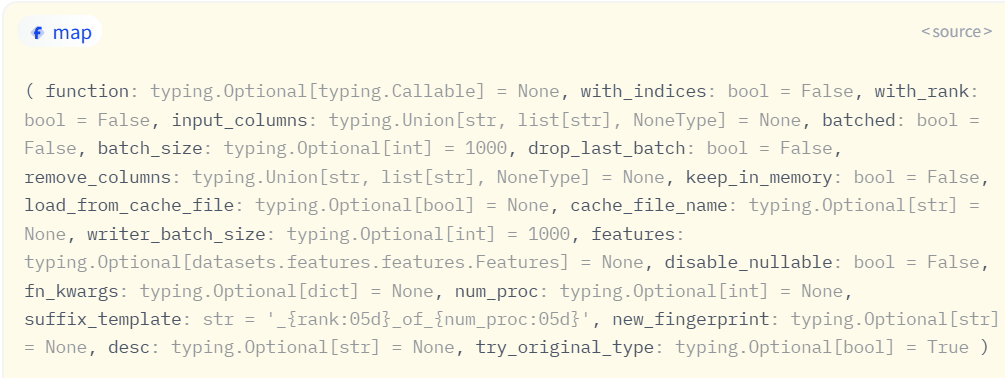

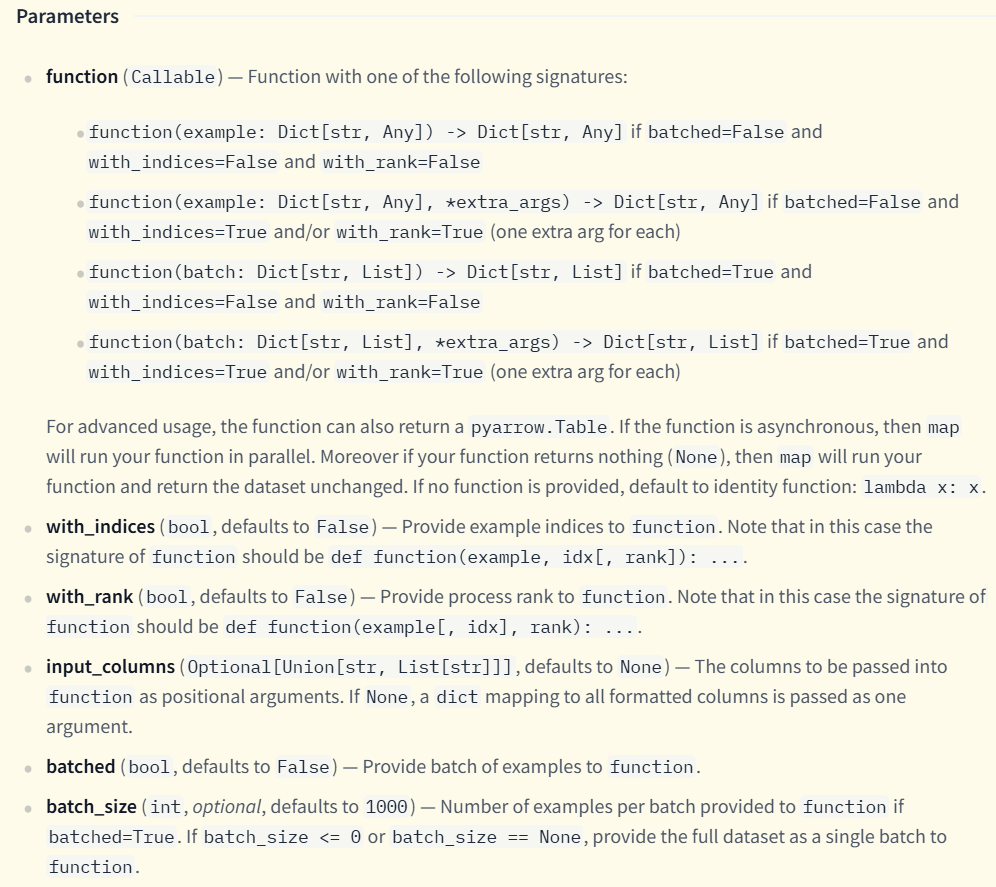

Example:

```
from datasets import load_dataset
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes", split="validation")
def add_prefix(example):
    example["text"] = "Review: " + example["text"]
    return example
ds = ds.map(add_prefix)
ds[0:3]["text"]
['Review: compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .',
 'Review: the soundtrack alone is worth the price of admission .',
 'Review: rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .']

# process a batch of examples
ds = ds.map(lambda example: tokenizer(example["text"]), batched=True)
# set number of processors
ds = ds.map(add_prefix, num_proc=4)
```

In [ ]:
# loading dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

## split dataset into train and test
dataset = dataset["train"].train_test_split(test_size=0.1)

## rename test split to validation
dataset["validation"] = dataset["test"]

## remove test split
del dataset["test"]

## map label indices to text labels
classes = dataset["train"].features["label"].names
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)

## show first example
dataset["train"][0]

Found cached dataset financial_phrasebank (/home/sourab/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'sentence': 'Finnish elevators and escalators maker KONE Corporation said on Tuesday ( 18 March ) that it has received a major order from Sir Robert McAlpine to supply all elevators and escalators for the Watermark Place project in the City of London .',
 'label': 2,
 'text_label': 'positive'}

**Preprocess dataset**

Initialize a tokenizer, and create a function to pad and truncate the `model_inputs` and `labels`:

Use the `map` function to apply the `preprocess_function` to the dataset. You can remove the unprocessed columns since the model doesn’t need them anymore:

Create a DataLoader from the `train` and `eval` datasets. Set `pin_memory=True` to speed up the data transfer to the GPU during training if the samples in your dataset are on a CPU.

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)


def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=2, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100  ## ignore padding in loss
    model_inputs["labels"] = labels
    return model_inputs


## apply preprocessing to dataset
processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)



#Apply preprocessing
train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

# define train and val dataloader
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

/home/sourab/transformers/src/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Running tokenizer on dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

**Train model**

Now we can setup your model and make sure it is ready for training. Specify the task in `PrefixTuningConfig`, create the base `t5-large model` from [AutoModelForSeq2SeqLM](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSeq2SeqLM), and then wrap the model and configuration in a [PeftModel](https://huggingface.co/docs/peft/main/en/package_reference/peft_model#peft.PeftModel). Feel free to print the PeftModel’s parameters and compare it to fully training all the model parameters to see how much more efficient it is!

In [ ]:
# creating model
peft_config = PrefixTuningConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model

Setup the optimizer and learning rate scheduler:

In [ ]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

Move the model to the GPU, and then write a training loop to begin!

In [ ]:
# training and evaluation
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )


 # calculate evaluation and training loss + perplexity
    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.56it/s]


epoch=0: train_ppl=tensor(2760654.5000, device='cuda:0') train_epoch_loss=tensor(14.8310, device='cuda:0') eval_ppl=tensor(1.0124, device='cuda:0') eval_epoch_loss=tensor(0.0124, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.05it/s]


epoch=1: train_ppl=tensor(2.7329, device='cuda:0') train_epoch_loss=tensor(1.0054, device='cuda:0') eval_ppl=tensor(1.0081, device='cuda:0') eval_epoch_loss=tensor(0.0080, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.05it/s]


epoch=2: train_ppl=tensor(2.1698, device='cuda:0') train_epoch_loss=tensor(0.7747, device='cuda:0') eval_ppl=tensor(1.0057, device='cuda:0') eval_epoch_loss=tensor(0.0057, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.06it/s]


epoch=3: train_ppl=tensor(2.0724, device='cuda:0') train_epoch_loss=tensor(0.7287, device='cuda:0') eval_ppl=tensor(1.0051, device='cuda:0') eval_epoch_loss=tensor(0.0051, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.74it/s]


epoch=4: train_ppl=tensor(1.7598, device='cuda:0') train_epoch_loss=tensor(0.5652, device='cuda:0') eval_ppl=tensor(1.0047, device='cuda:0') eval_epoch_loss=tensor(0.0047, device='cuda:0')


Let’s see how well the model performs on the validation set:

In [ ]:
# print accuracy
correct = 0
total = 0
for pred, true in zip(eval_preds, dataset["validation"]["text_label"]):
    if pred.strip() == true.strip():
        correct += 1
    total += 1
accuracy = correct / total * 100
print(f"{accuracy=} % on the evaluation dataset")
print(f"{eval_preds[:10]=}")
print(f"{dataset['validation']['text_label'][:10]=}")

accuracy=96.91629955947137 % on the evaluation dataset
eval_preds[:10]=['negative', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']
dataset['validation']['text_label'][:10]=['negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


97% accuracy in just a few minutes; pretty good!

**Share model**
You can store and share your model on the Hub if you’d like. Login to your Hugging Face account and enter your token when prompted:


```
from huggingface_hub import notebook_login

notebook_login()
```
Upload the model to a specifc model repository on the Hub with the push_to_hub function:

```
peft_model_id = "your-name/t5-large_PREFIX_TUNING_SEQ2SEQ"
model.push_to_hub("your-name/t5-large_PREFIX_TUNING_SEQ2SEQ", use_auth_token=True)
```
If you check the model file size in the repository, you’ll see that it is only 3.93MB! 🤏

In [ ]:
# saving model
peft_model_id = f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}"
model.save_pretrained(peft_model_id)

In [ ]:
## check adapter model size
ckpt = f"{peft_model_id}/adapter_model.bin"
!du -h $ckpt  # # Unix command to print file size

3,8M	t5-large_PREFIX_TUNING_SEQ_2_SEQ_LM/adapter_model.bin


**Inference**

Once the model has been uploaded to the Hub, anyone can easily use it for inference. Load the configuration and model:

In [ ]:
'''
from peft import PeftModel, PeftConfig

peft_model_id = "stevhliu/t5-large_PREFIX_TUNING_SEQ2SEQ"

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id)
'''

In [ ]:
from peft import PeftModel, PeftConfig

peft_model_id = f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}"

config = PeftConfig.from_pretrained(peft_model_id)
## load base model again
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)

## attach PEFT adapter
model = PeftModel.from_pretrained(model, peft_model_id)

Get and tokenize some text about financial news:

In [ ]:
'''
inputs = tokenizer(
    "The Lithuanian beer market made up 14.41 million liters in January , a rise of 0.8 percent from the year-earlier figure , the Lithuanian Brewers ' Association reporting citing the results from its members .",
    return_tensors="pt",
)
'''

Put the model on a GPU and generate the predicted text sentiment:

In [ ]:
model.eval()
i = 107
inputs = tokenizer(dataset["validation"][text_column][i], return_tensors="pt")
print(dataset["validation"][text_column][i])  ## print input sentence
print(inputs)  # show tokenized input

with torch.no_grad():
    outputs = model.generate(input_ids=inputs["input_ids"], max_new_tokens=10)
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

Acando AB ( ACANB SS ) fell 8.9 percent to 13.35 kronor , the lowest close since Dec. 11 .
{'input_ids': tensor([[ 4292,   232,    32,     3,  5359,    41,     3, 22029, 14972,     3,
          4256,     3,    61,  4728,  4848,  1298,  1093,    12,  8808,  2469,
             3, 22318,    29,   127,     3,     6,     8,  7402,   885,   437,
          4451,     5,   850,     3,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[   0, 2841,    1]])
['negative']


# **Second Example:**

In second part we want to classify whether a tweet is a complaint or not, using prefix-tuning.

In [ ]:
from transformers import AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, PrefixTuningConfig, TaskType, PeftType
import torch
from datasets import load_dataset
import os
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

device = "cuda"
model_name_or_path = "bigscience/bloomz-560m"
tokenizer_name_or_path = "bigscience/bloomz-560m"
peft_config = PrefixTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=30)

dataset_name = "twitter_complaints"
checkpoint_name = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
    "/", "_"
)
text_column = "Tweet text"
label_column = "text_label"
max_length = 64
lr = 3e-2
num_epochs = 50
batch_size = 8

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ought/raft", dataset_name)

classes = [k.replace("_", " ") for k in dataset["train"].features["Label"].names]
print(classes)
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["Label"]]},
    batched=True,
    num_proc=1,
)
print(dataset)
dataset["train"][0]

Found cached dataset raft (/home/sourab/.cache/huggingface/datasets/ought___raft/twitter_complaints/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sourab/.cache/huggingface/datasets/ought___raft/twitter_complaints/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84/cache-20a7622c86d80cdf.arrow
Loading cached processed dataset at /home/sourab/.cache/huggingface/datasets/ought___raft/twitter_complaints/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84/cache-5f1431311da05803.arrow


['Unlabeled', 'complaint', 'no complaint']
DatasetDict({
    train: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 3399
    })
})


{'Tweet text': '@HMRCcustomers No this is my first job',
 'ID': 0,
 'Label': 2,
 'text_label': 'no complaint'}

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(class_label)["input_ids"]) for class_label in classes])
print(target_max_length)


def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets, add_special_tokens=False)  # don't add bos token because we concatenate with inputs
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["train"]


train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

3


Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
def test_preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    model_inputs = tokenizer(inputs)
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
    return model_inputs


test_dataset = dataset["test"].map(
    test_preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

test_dataloader = DataLoader(test_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)
next(iter(test_dataloader))

In [ ]:
next(iter(train_dataloader))

In [ ]:
len(test_dataloader)

425

In [ ]:
next(iter(test_dataloader))

In [ ]:
# creating model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1474560 || all params: 560689152 || trainable%: 0.26299064191632515


In [ ]:
model

In [ ]:
model.peft_config

PrefixTuningConfig(peft_type=<PeftType.PREFIX_TUNING: 'PREFIX_TUNING'>, base_model_name_or_path='bigscience/bloomz-560m', task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=30, token_dim=1024, num_transformer_submodules=1, num_attention_heads=16, num_layers=24, encoder_hidden_size=1024, prefix_projection=False)

In [ ]:
# model
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        #         print(batch)
        #         print(batch["input_ids"].shape)
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.51it/s]


epoch=0: train_ppl=tensor(1.8325e+09, device='cuda:0') train_epoch_loss=tensor(21.3289, device='cuda:0') eval_ppl=tensor(2713.4180, device='cuda:0') eval_epoch_loss=tensor(7.9060, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.53it/s]


epoch=1: train_ppl=tensor(341.0600, device='cuda:0') train_epoch_loss=tensor(5.8321, device='cuda:0') eval_ppl=tensor(80.8206, device='cuda:0') eval_epoch_loss=tensor(4.3922, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.55it/s]


epoch=2: train_ppl=tensor(59.8778, device='cuda:0') train_epoch_loss=tensor(4.0923, device='cuda:0') eval_ppl=tensor(34.4593, device='cuda:0') eval_epoch_loss=tensor(3.5398, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.55it/s]


epoch=3: train_ppl=tensor(22.3307, device='cuda:0') train_epoch_loss=tensor(3.1060, device='cuda:0') eval_ppl=tensor(12.5947, device='cuda:0') eval_epoch_loss=tensor(2.5333, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.56it/s]


epoch=4: train_ppl=tensor(9.1697, device='cuda:0') train_epoch_loss=tensor(2.2159, device='cuda:0') eval_ppl=tensor(4.5289, device='cuda:0') eval_epoch_loss=tensor(1.5105, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.52it/s]


epoch=5: train_ppl=tensor(3.0172, device='cuda:0') train_epoch_loss=tensor(1.1043, device='cuda:0') eval_ppl=tensor(1.8092, device='cuda:0') eval_epoch_loss=tensor(0.5929, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.45it/s]


epoch=6: train_ppl=tensor(1.4885, device='cuda:0') train_epoch_loss=tensor(0.3978, device='cuda:0') eval_ppl=tensor(1.4449, device='cuda:0') eval_epoch_loss=tensor(0.3680, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.48it/s]


epoch=7: train_ppl=tensor(1.2967, device='cuda:0') train_epoch_loss=tensor(0.2598, device='cuda:0') eval_ppl=tensor(1.1587, device='cuda:0') eval_epoch_loss=tensor(0.1473, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=8: train_ppl=tensor(1.1305, device='cuda:0') train_epoch_loss=tensor(0.1227, device='cuda:0') eval_ppl=tensor(1.0874, device='cuda:0') eval_epoch_loss=tensor(0.0838, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.46it/s]


epoch=9: train_ppl=tensor(1.1608, device='cuda:0') train_epoch_loss=tensor(0.1491, device='cuda:0') eval_ppl=tensor(1.1461, device='cuda:0') eval_epoch_loss=tensor(0.1364, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.45it/s]


epoch=10: train_ppl=tensor(1.3172, device='cuda:0') train_epoch_loss=tensor(0.2755, device='cuda:0') eval_ppl=tensor(1.1320, device='cuda:0') eval_epoch_loss=tensor(0.1240, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.46it/s]


epoch=11: train_ppl=tensor(1.1437, device='cuda:0') train_epoch_loss=tensor(0.1343, device='cuda:0') eval_ppl=tensor(1.0676, device='cuda:0') eval_epoch_loss=tensor(0.0654, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.43it/s]


epoch=12: train_ppl=tensor(1.0651, device='cuda:0') train_epoch_loss=tensor(0.0630, device='cuda:0') eval_ppl=tensor(1.0735, device='cuda:0') eval_epoch_loss=tensor(0.0710, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=13: train_ppl=tensor(1.0607, device='cuda:0') train_epoch_loss=tensor(0.0589, device='cuda:0') eval_ppl=tensor(1.0399, device='cuda:0') eval_epoch_loss=tensor(0.0391, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.44it/s]


epoch=14: train_ppl=tensor(1.0351, device='cuda:0') train_epoch_loss=tensor(0.0345, device='cuda:0') eval_ppl=tensor(1.0260, device='cuda:0') eval_epoch_loss=tensor(0.0257, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.43it/s]


epoch=15: train_ppl=tensor(1.0217, device='cuda:0') train_epoch_loss=tensor(0.0215, device='cuda:0') eval_ppl=tensor(1.0168, device='cuda:0') eval_epoch_loss=tensor(0.0167, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.28it/s]


epoch=16: train_ppl=tensor(1.0152, device='cuda:0') train_epoch_loss=tensor(0.0151, device='cuda:0') eval_ppl=tensor(1.0117, device='cuda:0') eval_epoch_loss=tensor(0.0116, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.41it/s]


epoch=17: train_ppl=tensor(1.0102, device='cuda:0') train_epoch_loss=tensor(0.0101, device='cuda:0') eval_ppl=tensor(1.0088, device='cuda:0') eval_epoch_loss=tensor(0.0088, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.25it/s]


epoch=18: train_ppl=tensor(1.0083, device='cuda:0') train_epoch_loss=tensor(0.0083, device='cuda:0') eval_ppl=tensor(1.0073, device='cuda:0') eval_epoch_loss=tensor(0.0073, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.46it/s]


epoch=19: train_ppl=tensor(1.0070, device='cuda:0') train_epoch_loss=tensor(0.0070, device='cuda:0') eval_ppl=tensor(1.0064, device='cuda:0') eval_epoch_loss=tensor(0.0063, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.51it/s]


epoch=20: train_ppl=tensor(1.0059, device='cuda:0') train_epoch_loss=tensor(0.0059, device='cuda:0') eval_ppl=tensor(1.0057, device='cuda:0') eval_epoch_loss=tensor(0.0057, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=21: train_ppl=tensor(1.0056, device='cuda:0') train_epoch_loss=tensor(0.0056, device='cuda:0') eval_ppl=tensor(1.0052, device='cuda:0') eval_epoch_loss=tensor(0.0052, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.33it/s]


epoch=22: train_ppl=tensor(1.0050, device='cuda:0') train_epoch_loss=tensor(0.0050, device='cuda:0') eval_ppl=tensor(1.0049, device='cuda:0') eval_epoch_loss=tensor(0.0049, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.44it/s]


epoch=23: train_ppl=tensor(1.0049, device='cuda:0') train_epoch_loss=tensor(0.0049, device='cuda:0') eval_ppl=tensor(1.0045, device='cuda:0') eval_epoch_loss=tensor(0.0045, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.49it/s]


epoch=24: train_ppl=tensor(1.0043, device='cuda:0') train_epoch_loss=tensor(0.0043, device='cuda:0') eval_ppl=tensor(1.0043, device='cuda:0') eval_epoch_loss=tensor(0.0043, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=25: train_ppl=tensor(1.0042, device='cuda:0') train_epoch_loss=tensor(0.0042, device='cuda:0') eval_ppl=tensor(1.0040, device='cuda:0') eval_epoch_loss=tensor(0.0040, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.52it/s]


epoch=26: train_ppl=tensor(1.0039, device='cuda:0') train_epoch_loss=tensor(0.0039, device='cuda:0') eval_ppl=tensor(1.0039, device='cuda:0') eval_epoch_loss=tensor(0.0039, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.48it/s]


epoch=27: train_ppl=tensor(1.0038, device='cuda:0') train_epoch_loss=tensor(0.0038, device='cuda:0') eval_ppl=tensor(1.0037, device='cuda:0') eval_epoch_loss=tensor(0.0037, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.54it/s]


epoch=28: train_ppl=tensor(1.0036, device='cuda:0') train_epoch_loss=tensor(0.0036, device='cuda:0') eval_ppl=tensor(1.0035, device='cuda:0') eval_epoch_loss=tensor(0.0035, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.53it/s]


epoch=29: train_ppl=tensor(1.0034, device='cuda:0') train_epoch_loss=tensor(0.0034, device='cuda:0') eval_ppl=tensor(1.0034, device='cuda:0') eval_epoch_loss=tensor(0.0034, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=30: train_ppl=tensor(1.0034, device='cuda:0') train_epoch_loss=tensor(0.0034, device='cuda:0') eval_ppl=tensor(1.0033, device='cuda:0') eval_epoch_loss=tensor(0.0033, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=31: train_ppl=tensor(1.0033, device='cuda:0') train_epoch_loss=tensor(0.0033, device='cuda:0') eval_ppl=tensor(1.0032, device='cuda:0') eval_epoch_loss=tensor(0.0032, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.51it/s]


epoch=32: train_ppl=tensor(1.0031, device='cuda:0') train_epoch_loss=tensor(0.0031, device='cuda:0') eval_ppl=tensor(1.0031, device='cuda:0') eval_epoch_loss=tensor(0.0031, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.43it/s]


epoch=33: train_ppl=tensor(1.0030, device='cuda:0') train_epoch_loss=tensor(0.0030, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.46it/s]


epoch=34: train_ppl=tensor(1.0029, device='cuda:0') train_epoch_loss=tensor(0.0029, device='cuda:0') eval_ppl=tensor(1.0029, device='cuda:0') eval_epoch_loss=tensor(0.0029, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=35: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0029, device='cuda:0') eval_epoch_loss=tensor(0.0029, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.45it/s]


epoch=36: train_ppl=tensor(1.0027, device='cuda:0') train_epoch_loss=tensor(0.0027, device='cuda:0') eval_ppl=tensor(1.0028, device='cuda:0') eval_epoch_loss=tensor(0.0028, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=37: train_ppl=tensor(1.0027, device='cuda:0') train_epoch_loss=tensor(0.0027, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.46it/s]


epoch=38: train_ppl=tensor(1.0027, device='cuda:0') train_epoch_loss=tensor(0.0027, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.43it/s]


epoch=39: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0026, device='cuda:0') eval_epoch_loss=tensor(0.0026, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=40: train_ppl=tensor(1.0026, device='cuda:0') train_epoch_loss=tensor(0.0026, device='cuda:0') eval_ppl=tensor(1.0026, device='cuda:0') eval_epoch_loss=tensor(0.0026, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.33it/s]


epoch=41: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0025, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.49it/s]


epoch=42: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0025, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.47it/s]


epoch=43: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0025, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.43it/s]


epoch=44: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.50it/s]


epoch=45: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.49it/s]


epoch=46: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.39it/s]


epoch=47: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.40it/s]


epoch=48: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.87it/s]

epoch=49: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


In [ ]:
model.eval()
i = 16
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

Hey @nytimes your link to cancel my subscription isn't working and nobody is answering the chat. Please don't play that kind of stupid game.
{'input_ids': tensor([[227985,   5484,    915,  54078,   2566,   7782,  24502,   2632,   8989,
            427,  36992,   2670, 140711,  21994,  10789,    530,  88399,    632,
         183542,    368,  44799,     17,  29901,   5926,   7229,    861,  11596,
            461,  78851,  14775,     17,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,  54078,   2566,   7782,  24502,   2632,   8989,
            427,  36992,   2670, 140711,  21994,  10789,    530,  88399,    632,
         183542,    368,  44799,     17,  29901,   5926,   7229,    861,  11596,
            461,  78851,  14775,     17,  77658,    915,    210,  16449,   5952,
              3]], device='cuda:0')
["Tweet text : Hey @nytimes your 

You can push model to hub or save model locally.

- Option1: Pushing the model to Hugging Face Hub
```python
model.push_to_hub(
    f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace("/", "_"),
    token = "hf_..."
)
```
token (`bool` or `str`, *optional*):
    `token` is to be used for HTTP Bearer authorization when accessing remote files. If `True`, will use the token generated
    when running `huggingface-cli login` (stored in `~/.huggingface`). Will default to `True` if `repo_url`
    is not specified.
    Or you can get your token from https://huggingface.co/settings/token
```
- Or save model locally
```python
peft_model_id = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace("/", "_")
model.save_pretrained(peft_model_id)
```

In [ ]:
# saving model
peft_model_id = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace(
    "/", "_"
)
model.save_pretrained(peft_model_id)

In [ ]:
ckpt = f"{peft_model_id}/adapter_model.bin"
!du -h $ckpt

In [ ]:
from peft import PeftModel, PeftConfig

peft_model_id = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace(
    "/", "_"
)

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
model.to(device)
model.eval()
i = 4
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

@greateranglia Ok thanks...
{'input_ids': tensor([[227985,   5484,    915,   2566,  14173,   2960,  29906,    387,  20706,
          49337,   1369,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,   2566,  14173,   2960,  29906,    387,  20706,
          49337,   1369,  77658,    915,    210,   1936, 106863,      3]],
       device='cuda:0')
['Tweet text : @greateranglia Ok thanks... Label : no complaint']
